# Accessing BurnPro3D Data from Zarr Files

This notebook demonstrates how to access BurnPro3D output data stored in Zarr format.

1. Accessing the Zarr file from a given URL.
2. View metadata of the BurnPro3D run.
3. Explore different groups available in the Zarr directory, such as `spatial_ref`, `topography`, and `fuels-dens`.
4. Save the processed arrays as a georeferenced raster (.tif file) using Rasterio.

In [1]:
# import packages
import zarr
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.transform import from_origin

In [2]:
# pull in data with the url for the zarr file
url = 'https://wifire-data.sdsc.edu/data/burnpro3d/d/96/74/run_9674ad06-cf9b-41e9-b338-6be7ccd1bc3b/quicfire.zarr'
z = zarr.open(url)


### View the Metadata of the BurnPro3D Run

In [3]:
dict(z.attrs)

{'burn_area': {'coordinates': [[[-119.639117347, 37.536480244],
    [-119.638938785, 37.536581103],
    [-119.63878706, 37.536640813],
    [-119.638187038, 37.536613676],
    [-119.63807685, 37.53666795],
    [-119.637869681, 37.536809997],
    [-119.637600576, 37.536910624],
    [-119.63715247, 37.536909372],
    [-119.6370461, 37.536891474],
    [-119.636545664, 37.536810291],
    [-119.636249309, 37.536810152],
    [-119.635938692, 37.536886923],
    [-119.635635316, 37.537008586],
    [-119.635532539, 37.537042418],
    [-119.635159195, 37.537165642],
    [-119.634759512, 37.537203849],
    [-119.634042291, 37.537192823],
    [-119.632852741, 37.537075187],
    [-119.632752695, 37.537066154],
    [-119.632689839, 37.53707882],
    [-119.632063165, 37.537198673],
    [-119.631373393, 37.537324435],
    [-119.630856426, 37.537356232],
    [-119.6303736, 37.537202543],
    [-119.630028897, 37.537165169],
    [-119.629711539, 37.53718125],
    [-119.629545963, 37.53716917],
    [-119.6

### Explore Zarr Data
If you go to the link, you can see the groups available in the zarr directory: `fuels-dens`, `spatial_ref`, and `topography`.

Let's explore each.

`spatial_ref` - this is the spatial reference for the files, unlike the other groups, the data here is not stored in an array format. We can access the data using `.attrs`

In [4]:
dict(z['spatial_ref'].attrs)

{'GeoTransform': '-2048070.0 2.0 0.0 1866124.0 0.0 2.0',
 '_ARRAY_DIMENSIONS': [],
 'crs_wkt': 'PROJCS["NAD83 / Conus Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]',
 'false_easting': 0.0,
 'false_northing': 0.0,
 'geographic_crs_name': 'NAD83',
 'grid_mapping_name': 'albers_conical_equal_area',
 'horizontal_datum_name': 'North American Datum 1983',
 'inverse_flattening': 298.257222101,
 'latitude_of_pro

`topography` - this is the topography array.

In [5]:
#see that it is stored as an array, and see the dimensions of the array, and data type
z['topography']

<zarr.core.Array '/topography' (416, 669) float16>

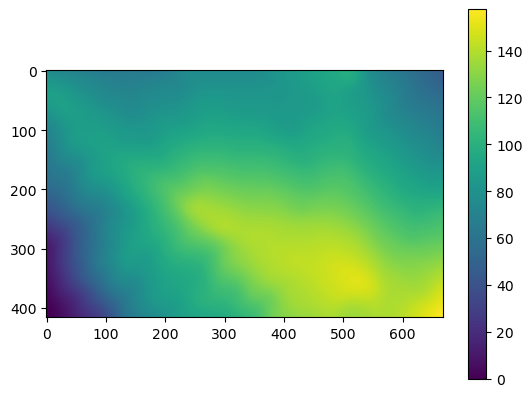

In [6]:
#let's plot the topography
# note that you will need to flip the arrays to be the north side up when you plot it

topo = z['topography'][...]

plt.imshow(np.flipud(topo))
plt.colorbar()

`fuels-dens` - this shows where fine fuel consumption occurred during the burn at different time steps. Check the metadata about the run to see the timestep interval (in seconds)

In [7]:
# look at the attributes
dict(z['fuels-dens'].attrs)

{'_ARRAY_DIMENSIONS': ['t0', 'z0', 'y0', 'x0'],
 'cache_max': 8.0,
 'cache_min': 0.0,
 'description': 'fuel density',
 'grid_mapping': 'spatial_ref',
 'units': 'kg/m^3'}

In [8]:
# look at the array information
z['fuels-dens']

<zarr.core.Array '/fuels-dens' (119, 68, 416, 669) float16>

In [9]:
# Prepare initial and final fuel density arrays
# note that you will need to flip the arrays to be the north side up when you plot it

initial_density = np.float32(z['fuels-dens'][0,:,:,:])

final_layer_size = z['fuels-dens'].shape[0] - 1
final_density = np.float32(z['fuels-dens'][final_layer_size,:,:,:])


initial_density_flip = initial_density[:,::-1,:]
final_density_flip = final_density[:,::-1,:]

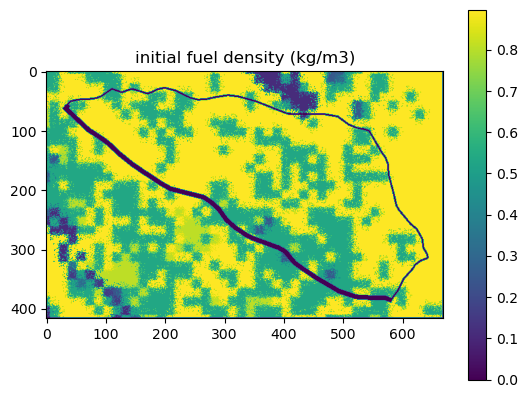

In [10]:
#plot the initial fuel density at the surface, fuel density data is from FastFuels

plt.imshow(initial_density_flip[0,:,:])
plt.title('initial fuel density (kg/m3)')
plt.colorbar()

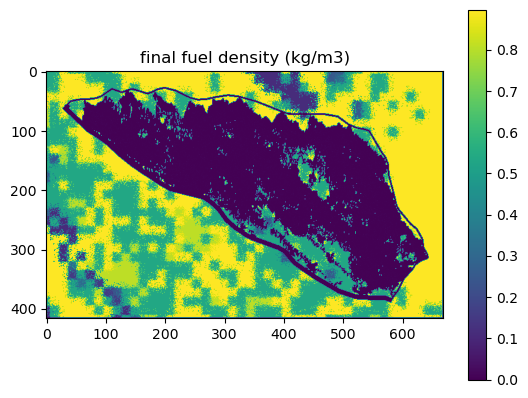

In [11]:
#plot the final fuel density at the surface, you can see where the surface was burned

plt.imshow(final_density_flip[0,:,:])
plt.title('final fuel density (kg/m3)')
plt.colorbar()

### Save the arrays as a .tif file

In [12]:
# get the correct transform and spatial reference from the attributes

original_transform = str.split(dict(z['spatial_ref'].attrs)['GeoTransform'], ' ')
nt, nz, ny, nx = z['fuels-dens'].shape
x_res, y_res, z_res = dict(z.attrs)['resolution'] #the resolution in m

#need to adjust the original transform to change the origin from min y to max y through calculations
transform = from_origin(float(original_transform[0]), 
                        float(original_transform[3]) + ny * y_res, 
                        float(original_transform[1]), 
                        float(original_transform[5]))
crs = rasterio.crs.CRS.from_string(dict(z['spatial_ref'].attrs)['crs_wkt'])

print('transform is ')
transform

transform is 


Affine(2.0, 0.0, -2048070.0,
       0.0, -2.0, 1866956.0)

In [13]:
# use rasterio to save one time step (2D image) as .tif file
# to save multiple time steps, change the count to the number of timesteps you want and loop through

rastername = 'raster.tif'
im = final_density_flip[0,:,:] #2d image you want to save as raster

new_dataset = rasterio.open(rastername, 'w', 
                            driver='GTiff',
                            height = ny, 
                            width = nx,
                            count=1, 
                            dtype=str(im.dtype),
                            crs=crs,
                            transform=transform)

new_dataset.write(im, 1)
new_dataset.close()